# Atmospheric Radiative Model Interface

##### The typical packages to import.

In [1]:
import astropy.constants as C
import astropy.units as U
import numpy as N

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import datetime

/Users/arthur/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


##### The planet class contains all the methods used for the geometry of the planet-star system.

In [2]:
from planet_class import Planet

##### Import the modules for the thermal model (currently a blackbody model).

In [3]:
from thermal import blackbody as thermal_model

##### Import the system properties and data of the desired planet (contained in a Python dictionary in a separate file).

In [4]:
#from data.planet.HATP2b import HATP2b as exoplanet
#from data.planet.HD80606b import HD80606b as exoplanet
from data.planet.HD189733b import HD189733b as exoplanet
#from data.planet.HD209458b import HD209458b as exoplanet

##### Import the instrumental response data (currently for the Spitzer IRAC bands) and the routine to convert surface temperatures to observed planet-star flux ratios in a given band.

In [5]:
from data.bandpass.spitzer_IRAC import spitzer_IRAC as instrument
from data.bandpass.response import light_curve

##### Import the likelihood calculation routine.

In [6]:
from stats.gaussian import log_likelihood
from stats.metropolis import MCMC

##### Import any visualization routines needed.

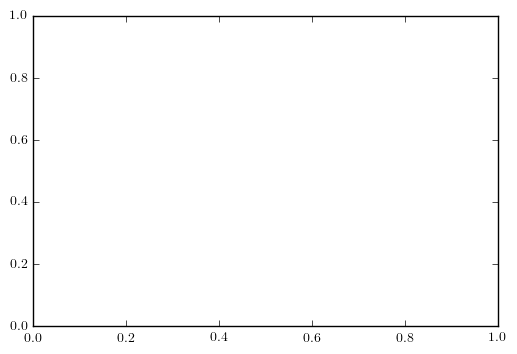

In [7]:
from visualization import multi_animation
from visualization.style import colors
from visualization.lightcurve_plot import LightCurvePlot
from visualization.orbit_plot import OrbitPlot
from visualization.surface_plot import SurfacePlot

##### Create a planet instance with the user-supplied system properties.

In [8]:
planet = Planet(exoplanet.system_properties)

##### Specify the spatial and time resolution for the calculations, including the number of orbits to run.

In [9]:
planet.set_resolution(longitude_resolution = 18,
                      latitude_resolution = 8,
                      time_resolution = 200,
                      num_orbits = 2)

##### Specify ranges to be used for the grid in parameter space to be sampled. Make sure that the rotation period is the first parameter. For the blackbody model one also specifies the radiative timescale at 1000 K, the "nightside" (baseline) temperature of the planet, and the global Bond albedo.

In [ ]:
prot = N.linspace(1.0, 2.0, num=1) * planet.pseudosynchronous_period()
t1000 = N.linspace(0, 25, num=1)
#t1000 = N.linspace(5, 5, num=1)
t1000[0] += 0.001
Tn = N.linspace(982.4, 2000, num=1) * U.K
#Tn = N.linspace(250, 250, num=1)
#Tn[0] += 0.001
albedo = N.linspace(0.065, 0.6, num=1)

parameters = [prot, t1000*U.hr, Tn, albedo]
param_grid = N.meshgrid(prot, t1000*U.hr, Tn, albedo)

##### A wrapper function using the thermal model and light curve routines to start with a set of specified parameter values and return a light curve. This function will be passed to the statistical likelihood function.

In [10]:
def generate_model(parameters, spectral_array):
    temperature_map = thermal_model.temperatures(planet_object=planet, parameters=parameters)
    model = light_curve(planet, temperature_map, spectral_array, parameters=parameters)
    return {'temp': temperature_map, 'model': model}

##### For troubleshooting only: generate a synthetic data set given a predetermined set of "true" parameter values.

In [ ]:
test_parameters = [N.array([1])*planet.pseudosynchronous_period(), N.array([5])*U.hr, N.array([250])*U.K, N.array([0.1])]

x = [generate_model(test_parameters, instrument.bandpass[band]) for band in exoplanet.data]
y = [q['model'].T[40:] for i, q in enumerate(x)]
synthetic_data = {}
for i, band in enumerate(exoplanet.data):
    synthetic_data[band] = {'t': (planet.times[40:] - 2*planet.P)/U.d,
                            'flux': y[i].reshape(40)}

### MCMC LIKELIHOOD SEARCH
##### First define a (log) prior function that unpacks a set of parameters.

In [11]:
def mcmc_prior(parameters):
    p, r, T, a = parameters
    lnp = N.where(p>0, 0, -N.inf)
    lnp = N.where(r>0, lnp, -N.inf)
    lnp = N.where(T>0, lnp, -N.inf)
    lnp = N.where(0<=a, lnp, -N.inf)
    lnp = N.where(a<=1, lnp, -N.inf)
    return lnp

In [15]:
starting_position = {'values': [1, 15, 600, 0.1],
                     'units': [planet.pseudosynchronous_period(), U.hr, U.K, 1]}

num_walkers = 1
num_steps = 5
step_size = [0.1, 0.1, 0.1, 0.1]

##### Run this section to simultaneously fit data in each available band with a single set of parameters.

In [ ]:
mcmc_model = MCMC(planet_object = planet,
                  data = [exoplanet.data[band] for band in exoplanet.data],
                  spectral_array = [instrument.bandpass[band] for band in exoplanet.data],
                  model_function = generate_model)
mcmc_model.set_prior(mcmc_prior)
mcmc_model.set_initial_position(starting_position)
samples = mcmc_model.run_samples(num_walkers=num_walkers, num_steps=num_steps, step_size=step_size)

##### Run this section to fit data in each available band, separately.

In [16]:
mcmc_model = {}
samples = {}
for band in exoplanet.data:
    print "Band: {0}".format(band)
    mcmc_model[band] = MCMC(planet_object = planet,
                            data = [exoplanet.data[band]],
                            spectral_array = [instrument.bandpass[band]],
                            model_function = generate_model)
    mcmc_model[band].set_prior(mcmc_prior)
    mcmc_model[band].set_initial_position(starting_position)
    samples[band] = mcmc_model[band].run_samples(num_walkers=num_walkers, num_steps=num_steps, step_size=step_size)

Band: 4p5
[<Quantity 2.218575143 d>, <Quantity 15.0 h>, <Quantity 600.0 K>, 0.10000000000000001]
1
[<Quantity 1.8517937398148197 d>, <Quantity 14.692394898259062 h>, <Quantity 603.2433731081941 K>, 0.097183615722172129]
[<Quantity 2.218575143 d>, <Quantity 15.0 h>, <Quantity 600.0 K>, 0.10000000000000001]
2
[<Quantity 1.743131975934159 d>, <Quantity 15.609245395558021 h>, <Quantity 589.0327615684582 K>, 0.098992714182913416]
[<Quantity 1.8517937398148197 d>, <Quantity 14.692394898259062 h>, <Quantity 603.2433731081941 K>, 0.097183615722172129]
3
[<Quantity 2.036588873798945 d>, <Quantity 16.509497066637756 h>, <Quantity 560.3531019723318 K>, 0.10638068710103545]
[<Quantity 1.8517937398148197 d>, <Quantity 14.692394898259062 h>, <Quantity 603.2433731081941 K>, 0.097183615722172129]
4
[<Quantity 1.5774238651120378 d>, <Quantity 13.457056506417572 h>, <Quantity 631.8373021382041 K>, 0.085602485190771543]
[<Quantity 1.8517937398148197 d>, <Quantity 14.692394898259062 h>, <Quantity 603.2433

##### Save MCMC outputs: the record of walker positions in parameter space, and the record of log likelihoods at those positions.

In [17]:
with open('{0}_{1}_mc.npy'.format(datetime.date.today(), planet.name), 'w') as mc_file:
    N.save(mc_file, samples)

In [ ]:
with open('{0}_{1}_mc_pos.npz'.format(datetime.date.today(), planet.name), 'w') as mc_file:
    N.savez(mc_file, samples['3p6']['pos'], samples['4p5']['pos'], samples['8p0']['pos'])
    
with open('{0}_{1}_mc_logl.npz'.format(datetime.date.today(), planet.name), 'w') as mc_file:
    N.savez(mc_file, samples['3p6']['logl'], samples['4p5']['logl'], samples['8p0']['logl'])

##### If there are saved MCMC outputs we want to use, import them here.

In [22]:
mc_file = N.load('2016-12-12_HD189733b_mc.npy')[()]

[[ 2404.4913614 ]
 [ 2404.4913614 ]
 [ 2404.4913614 ]
 [ 2381.43525591]
 [ 2380.3770063 ]]


In [ ]:
logl_file = N.load('2016-12-08_HD189733b_mc_logl.npz')
#mc_logl = {'3p6': logl_file['arr_0'], '4p5': logl_file['arr_1'], '8p0': logl_file['arr_2']}
#mc_logl = {'4p5': logl_file['arr_0'], '8p0': logl_file['arr_1']}
mc_logl = {'3p6': logl_file['arr_0'], '4p5': logl_file['arr_1']}
#mc_logl = {'4p5': logl_file['arr_0']}

In [ ]:
pos_file = N.load('2016-12-08_HD189733b_mc_pos.npz')
#mc_pos = {'3p6': pos_file['arr_0'], '4p5': pos_file['arr_1'], '8p0': pos_file['arr_2']}
#mc_pos = {'4p5': pos_file['arr_0'], '8p0': pos_file['arr_1']}
mc_pos = {'3p6': pos_file['arr_0'], '4p5': pos_file['arr_1']}
#mc_pos = {'4p5': pos_file['arr_0']}

In [ ]:
mc_fit = {}
for band in exoplanet.data:
    print band
    mc_fit[band] = mc_pos[band][-1].reshape(4) * [planet.pseudosynchronous_period(), U.hr, U.K, 1]
    print mc_fit[band]

#mc_fit['4p5'] = mc_fit['3p6']    
#mc_fit['4p5'][0] = 2. * planet.pseudosynchronous_period()
#mc_fit['4p5'][1] = 16*U.hr
#mc_fit['4p5'][2] = 1400*U.K
#mc_fit['4p5'][3] = 1.0
print mc_fit['3p6'][0] / planet.pseudosynchronous_period()
print mc_fit['4p5'][0] / planet.pseudosynchronous_period()
#print mc_fit['8p0'][0] / planet.pseudosynchronous_period()

##### Plot the walker positions along each parameter dimension.

In [ ]:
burn_in = 250

fig, axarr = plt.subplots(4)
for i in range(4):
    for band in exoplanet.data:
        axarr[i].plot((mc_pos[band].T)[i][0],color=colors.color_datlab[band])
    #axarr[i].axvline(burn_in,color='red',linestyle='dashed')
#plt.title(param_name)
#axarr[2].set_ylim((0,1000))
plt.savefig('{0}_{1}_mc.pdf'.format(datetime.date.today(), planet.name))

### GRID LIKELIHOOD SEARCH
##### Call the statistical likelihood function and save the output as an array in parameter space. 'parallel' runs every parameter in parallel using broadcasting in Numpy. If the array is too large, a memory error might result, so use 'serial' instead. Parallel is faster for small array dimensions.

In [ ]:
logls = {}
for band in exoplanet.data:
    print "Band: {0}".format(band)
    logls[band] = log_likelihood(planet_object = planet,
                                 data = exoplanet.data[band],
                                 spectral_array = instrument.bandpass[band],
                                 model_function = generate_model,
                                 parameters = parameters,
                                 opt = 'serial')

##### Option to save the output in a numpy array file.

In [ ]:
with open('{0}_{1}_grid.npz'.format(datetime.date.today(), planet.name), 'w') as grid_file:
    N.savez(grid_file, logls)

##### Option to load an existing saved log likelihood array file.

In [ ]:
logls_file = N.load('2016-11-28_HATP2b_PSR_grid.npz')
logls = logls_file['arr_0'][()]

In [ ]:
print planet.pseudosynchronous_period() / planet.P

##### Pull the most favorable parameter values and make a grid of that single set to plot the flux curve(s). Then generate models for the most favorable parameters in each band.

In [ ]:
best_parameters = {}
best_rotation = {}
best_paramgrid = {}
best_model = {}

for band in exoplanet.data:
#for band in synthetic_data:
    #best_parameters[band] = [par[j].reshape(1)[0] for par, j in zip(parameters, logls[band]['index'])]
    best_parameters[band] = mc_fit[band]
    best_rotation[band] = best_parameters[band][0]
    best_paramgrid[band] = N.meshgrid(*best_parameters[band])
    
    #For purposes of plotting and displays, let's bump up the resolution.
    #We only need to generate a single model for each band.
    planet.set_resolution(longitude_resolution = 360,
                          latitude_resolution = 180,
                          time_resolution = 200,
                          num_orbits = 2)
    
    best_model[band] = generate_model(best_paramgrid[band], instrument.bandpass[band])
    #best_model[band]['model'] = best_model[band]['model'].reshape(planet.time_resolution*planet.num_orbits)
    #best_model[band]['temp'] = best_model[band]['temp'].reshape(planet.time_resolution*planet.num_orbits, planet.latitude_resolution+1, planet.longitude_resolution+1)

##### Plot a color contour plot in 2D of the log likelihoods as functions of 2 parameters. Overlay the walker trajectories in the 2D space.

In [ ]:
x, y = N.meshgrid(t1000, albedo)
print N.shape(x)
plt.pcolor(x, y, logls['8p0']['logl'].reshape(51,51).T, cmap='cubehelix_r')
plt.colorbar()
for band in exoplanet.data:
    plt.plot(mc_pos[band].T[1][0], mc_pos[band].T[3][0], color=colors.color_datlab[band], alpha=0.5)
plt.ylabel(r'Albedo')
plt.ylim([0,0.5])
plt.xlabel(r'$\tau_{1000}$ (hr)')
#plt.ylim([0,150])
plt.title(r'8.0 $\mu$m')
plt.savefig('{0}_{1}_loglgrid_8p0_PSR_250K.pdf'.format(datetime.date.today(), planet.name))
plt.clf()

##### Create some plot objects. The orbit plot shows the outline and motion/phases over the orbit, showing the rotation. The surface plot shows the evolution of surface temperatures, but can be used to show any planet surface quantity over time.

In [ ]:
lightcurve_plot = LightCurvePlot(planet, exoplanet.data, best_model, best_parameters)
orbit_plot = OrbitPlot(planet,
                       rotation_period = best_rotation['4p5'])
surface_plot = SurfacePlot(planet,
                           rotation_period = best_rotation['4p5'],
                           map_array = best_model['4p5']['temp'].reshape(planet.time_resolution*planet.num_orbits, planet.latitude_resolution+1, planet.longitude_resolution+1))

##### Plot the data vs. models. The models shown correspond to the best-fit parameters for each band, which may or may not agree with each other.

In [ ]:
showman = N.genfromtxt('data/planet/HD209458b/showman2009_209458.csv', delimiter=',')
#showman = N.genfromtxt('data/planet/HD189733b/showman2009_3p6_Z1_189733.csv', delimiter=',')
sh3_x = showman[:,0]
sh3_x = N.where(sh3_x > 0.5, sh3_x-1, sh3_x) * planet.P
sh3_y = showman[:,1]

#showman = N.genfromtxt('data/planet/HD189733b/showman2009_4p5_Z1_189733.csv', delimiter=',')
#sh4_x = showman[:,0]
#sh4_x = N.where(sh4_x > 0.5, sh4_x-1, sh4_x) * planet.P
#sh4_y = showman[:,1]

In [ ]:
fig, ax = plt.subplots()
lightcurve_plot.draw(axis=ax, save=False)
#ax.scatter(sh3_x, sh3_y, color='blue', label='Showman+ 09')
#ax.scatter(sh4_x, sh4_y, color='red', label='Showman+ 09')
#plt.savefig('showman_sim_209458.pdf')

##### This animation routine accepts a list of plot objects to animate. Here I chose the orbit and surface maps.

In [ ]:
animation = multi_animation.draw(planet, [orbit_plot, surface_plot])



##### Plot a grid of likelihood contour maps, showing the regions of most favorable parameter values for each wavelength band.

In [ ]:
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

num_columns = N.sum(wavelengths_use)
column_order = [N.sum(wavelengths_use[:n]) for n in xrange(len(wavelengths_use))]
num_rows = N.shape(planet.beta)[2]

likelihood_figure, axes = plt.subplots(num_rows, num_columns, sharex=True)

level_min = N.ceil(N.min([logl[key]['logl'] for key in logl.keys()]))
level_max = N.ceil(N.max([logl[key]['logl'] for key in logl.keys()]))
level_step = 10**(N.floor(N.log10(level_max))-1)
levels = N.arange(start=level_min, stop=level_max, step=2*level_step)

for i, row in enumerate(axes):
    for j, cell in enumerate(row):
        cell.yaxis.tick_right()
        if use_3p6 and j == column_order[0]:
            cell.set_axis_bgcolor('#D9B2F0')
            im = cell.contour(rot_psr, t_rad, logl['3p6']['logl'][:,:,num_rows-(i+1)].T, levels, origin='lower', cmap=cm.plasma)
            if i == 0: cell.set_title(r'$3.6 \mu$m', fontsize=15, color='#6E209C')
        if use_4p5 and j == column_order[1]:
            im = cell.contour(rot_psr, t_rad, logl['4p5']['logl'][:,:,num_rows-(i+1)].T, levels, origin='lower', cmap=cm.plasma)
            cell.set_axis_bgcolor('#FFD4BA')
            if i == 0: cell.set_title(r'$4.5 \mu$m', fontsize=15, color='#E97025')
        if use_5p8 and j == column_order[2]:
            im = cell.contour(rot_psr, t_rad, logl['5p8']['logl'][:,:,num_rows-(i+1)].T, levels, origin='lower', cmap=cm.plasma)
            cell.set_axis_bgcolor('#C5F8B5')
            if i == 0: cell.set_title(r'$5.8 \mu$m', fontsize=15, color='#47C61F')
        if use_8p0 and j == column_order[3]:
            im = cell.contour(rot_psr, t_rad, logl['8p0']['logl'][:,:,num_rows-(i+1)].T, levels, origin='lower', cmap=cm.plasma)
            cell.set_axis_bgcolor('#F8B5D2')
            if i == 0: cell.set_title(r'$8.0 \mu$m', fontsize=15, color='#C51F68')
        
        if j == 0: cell.set_ylabel('%i' % nighttemp[num_rows-(i+1)].value, fontsize=12)
        if j != num_columns-1:
            cell.yaxis.set_ticklabels([])
            
        #im = cell.imshow(likelihoods[j,:,:,i], interpolation='bilinear', origin='lower', cmap=cm.viridis)
        cell.clabel(im, inline=1, fmt='%i', fontsize=8)
        
likelihood_figure.text(0.5, 0.01, r'$P_{\mathrm{rot}}/P_{\mathrm{PSR}}$', fontsize=15, ha='center')
likelihood_figure.text(0.97, 0.5, r'$t_{\mathrm{rad}}$ (hr) at 1000 K', fontsize=15, va='center', rotation='vertical')
likelihood_figure.text(0.03, 0.5, r'$T_{\mathrm{n}}$ (K)', fontsize=15, va='center', rotation='vertical')
likelihood_figure.tight_layout
plt.savefig('{0}_likelihood_{1}.eps'.format(datetime.date.today(), planet.name))

##### This function allows us to estimate the uncertainty in our best-fit parameters by running a bootstrap routine.

In [ ]:
def bootstrap(data, response, passband, num_samples):
    variance = 0
    best_values = best_grid(logl[passband])
    betas, rots, nighttemps = best_values['mesh']
    planet.set_custom_parameters(beta=betas,
                               rotation_period=rots,
                               nightside_temperature=nighttemps)
    planet.set_albedo(best_values['albedo'])
    data_resample = data.copy()
    for i in xrange(num_samples):
        resample = N.random.choice(range(N.shape(data)[0]), size=N.shape(data)[0], replace=True)
        for j in xrange(N.shape(data)[0]):
            data_resample.values[j] = N.array([data.t[resample[j]], data.flux[resample[j]]])
        logl_resample = planet.log_likelihood(data_resample, response, time_cut)
        var_i = (logl_resample['logl'] - best_values['logl'])**2 / num_samples
        variance += var_i
    
    return N.sqrt(variance)